# Mooomentums
Mooom is a strategy that heavily relies on momentum. It enriches dataframe with simple momentum and industrial momentum factors. Returns will be substracted by a cross-sectional median.

In [475]:
from functools import reduce
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import warnings
warnings.filterwarnings('ignore')

In [476]:
df = pd.read_parquet("../data/compustat_ibes_raw_alpha.1.parquet")

In [477]:
def conf(clf, X_test, y_test):
    f, ax = plt.subplots(figsize=(4.8, 4.8))
    y_test_pred = clf.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    conf_ax = sns.heatmap(
        conf_mat, ax=ax, annot=True, fmt="", cmap=plt.cm.Blues, cbar=False
    )
    conf_ax.set_xlabel("Predicted")
    conf_ax.set_ylabel("True")

In [478]:
def extreme(df):
    """Retain the 20% values that are the smallest and the 20% that are the largest."""
    top = df.y.quantile(0.8)
    low = df.y.quantile(0.2)
    return df[(df.y < low) | (df.y > top)]

In [479]:
def mooom(df):
    """
    Mooom is a strategy that heavily relies on momentum.
    It enriches dataframe with simple momentum and industrial momentum factors. 
    Returns will be substracted by a cross-sectional median.
    """
    df_mom = df[["classification",
                 "mcap",
                 "act",
                 "ceq",
                 "cogs",
                 "lct",
                 "nicon",
                 "revt",
                 "xrd",
                 "prccd",
                 "close"]]
    df_mom["profitability_roe"]=df_mom.nicon / df_mom.ceq
    df_mom["intangible_rdm"] = df_mom.xrd / df_mom.mcap
    df_mom["liquid_cur"] = df_mom.act / df_mom.lct
    df_mom["market_pe"] = df_mom.mcap / (df_mom.nicon * 10 ** 6)
    df_mom["market_mb"] = df_mom.mcap / (df_mom.ceq * 10 ** 6)
    df_mom["52wk_high"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x) - np.log(x.rolling(12, min_periods=1).max()))
    df_mom["mom_12m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x.shift(2))-np.log(x.shift(13)))
    df_mom["mom_6m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x).shift(2) - np.log(x.shift(7)))
    df_mom["mom_1m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x) - np.log(x.shift(1)))
    df_mom["ind_mom_12m"] = df_mom.groupby(["date", "classification"]).mom_12m.transform("mean")
    df_mom["ind_mom_6m"] = df_mom.groupby(["date", "classification"]).mom_6m.transform("mean")
    df_mom["ind_mom_1m"] = df_mom.groupby(["date", "classification"]).mom_1m.transform("mean")
    df_mom["log_return"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x.shift(-3)) - np.log(x))
    df_mom["y"] = df_mom.groupby("date").log_return.transform(lambda x: (x - x.median()).clip(-1,1))
    return df_mom.loc[df.prccd > 5, ["mcap",
                                     "profitability_roe",
                                     "intangible_rdm",
                                     "liquid_cur",
                                     "market_mb",
                                     "market_pe",
                                     "52wk_high",
                                     "mom_12m",
                                     "mom_6m",
                                     "mom_1m",
                                     "ind_mom_12m",
                                     "ind_mom_6m",
                                     "ind_mom_1m",
                                     "y"]].dropna()

In [480]:
df_mom = mooom(df)

## Regression

In [89]:
def r2(y_true, y_pred):
    r2 = 1 - np.sum((y_true - y_pred) ** 2)/np.sum(y_true ** 2)
    return r2

r2_score = make_scorer(r2)

In [171]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train = df_train["y"].to_numpy()
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = df_test["y"].to_numpy()

In [172]:
xgb_reg = XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
xgb_fit = xgb_reg.fit(X_train, y_train)
train_score = r2_score(xgb_reg, X_train, y_train)
test_score = r2_score(xgb_reg, X_test, y_test)
print(f"R2 on training set: {train_score}\nR2 on test set: {test_score}")

R2 on training set: 0.08926540338353117
R2 on test set: 0.027067763216712337


## Binary Classification

In [204]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train = np.where(df_train.y > 0, 0, 1)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = np.where(df_test.y > 0, 0, 1)

Accuracy on training set: 0.5890400202413255
Accuracy on test set: 0.5606404113591212
              precision    recall  f1-score   support

        sell       0.57      0.70      0.63     22788
         buy       0.54      0.40      0.46     19997

    accuracy                           0.56     42785
   macro avg       0.56      0.55      0.55     42785
weighted avg       0.56      0.56      0.55     42785



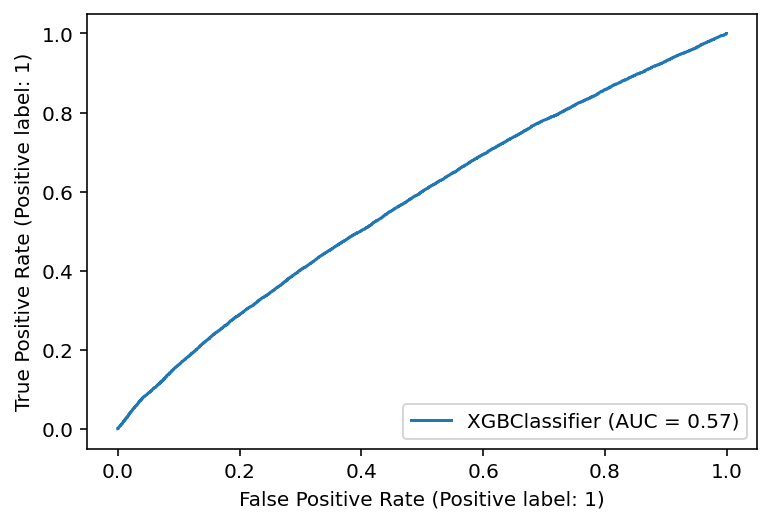

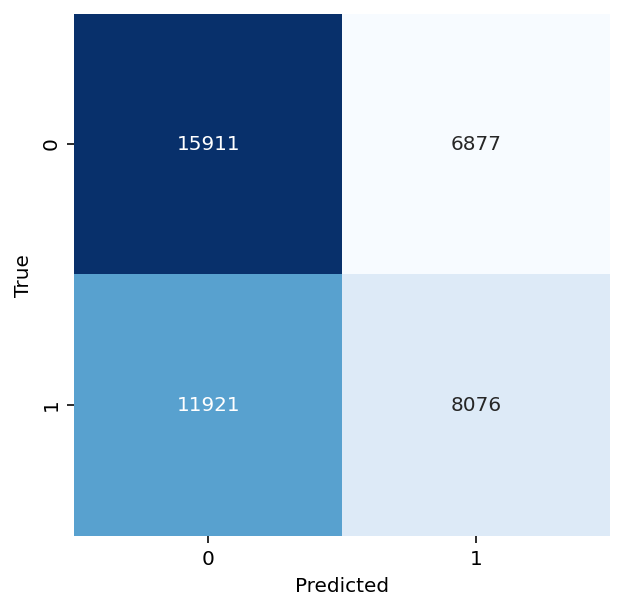

In [205]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
plot_roc_curve(xgb_clf, X_test, y_test)
conf(xgb_clf, X_test, y_test)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", "buy"]))

## Multi Classification

In [481]:
def threshold(y):
    thres = 0.1
    y_0 = np.where(y < -thres, -1, y)
    y_1 = np.where((y <= thres) & (y >= -thres), 0, y_0)
    y_2 = np.where(y > thres, 1, y_1)
    return y_2

In [482]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False).groupby("date").apply(extreme)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train= threshold(df_train.y)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test= threshold(df_test.y)

Accuracy on training set: 0.599542234332425
Accuracy on test set: 0.2277667406801449
              precision    recall  f1-score   support

        sell       0.24      0.47      0.32      7102
        hold       0.00      0.00      0.00     26866
         buy       0.22      0.72      0.34      8817

    accuracy                           0.23     42785
   macro avg       0.15      0.40      0.22     42785
weighted avg       0.09      0.23      0.12     42785



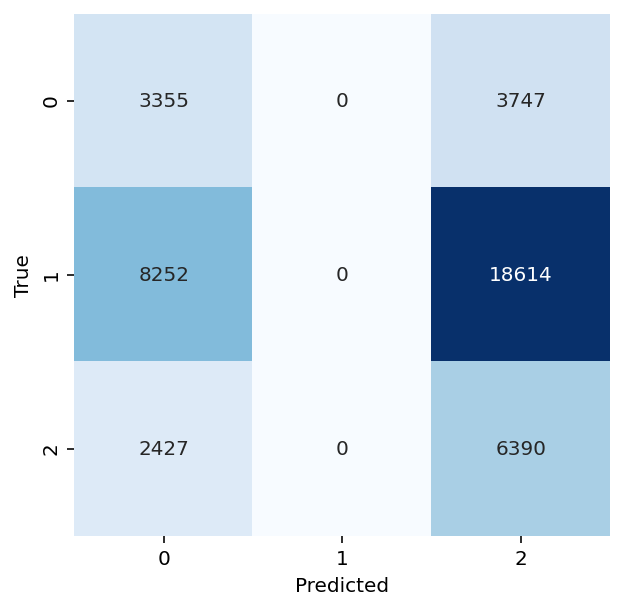

In [483]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred= xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
conf(xgb_clf, X_test, y_test)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", "hold", "buy"]))

## Portfolio Return

In [591]:
df_train = df_mom.xs(slice("2002-01-01", "2008-01-01"), level="date", drop_level=False).groupby("date").apply(extreme)
df_test = df_mom.xs(slice("2008-01-01", "2012-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train= threshold(df_train.y)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = threshold(df_test.y)
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred= xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", "hold", "buy"]))

Accuracy on training set: 0.620571852952098
Accuracy on test set: 0.25717061631394417
              precision    recall  f1-score   support

        sell       0.26      0.56      0.35      9865
        hold       0.00      0.00      0.00     25670
         buy       0.26      0.57      0.35     11811

    accuracy                           0.26     47346
   macro avg       0.17      0.37      0.24     47346
weighted avg       0.12      0.26      0.16     47346



In [592]:
def frame_to_signal(frame, estimator):
    X = frame.drop(columns="y").to_numpy()
    long_signal = estimator.predict_proba(X)[:, -1]
    short_signal = estimator.predict_proba(X)[:, 0]
    return pd.DataFrame(data={"long_signal": long_signal, "short_signal": short_signal}, index=frame.index)

In [593]:
def month_to_day(position, t):
    date = position.date.iloc[0]
    date_index = pd.date_range(
        date + DateOffset(days=1),
        date + DateOffset(months=t),
        freq="D",
        name="date",
    )
    return (
        position
        .drop(columns="gvkey")
        .set_index("date")
        .sort_index()
        .reindex(date_index, method="ffill")
    )

In [594]:
def signal_to_position(signal, n, t):
    long_idx = signal.long_signal.groupby("date", group_keys=False).apply(lambda x: x.sort_values(ascending=False).head(n)).index
    short_idx = signal.short_signal.groupby("date", group_keys=False).apply(lambda x: x.sort_values(ascending=False).head(n)).index
    long_position = pd.Series(1, index=long_idx, name="long_position").reset_index().groupby(["gvkey", "date"]).apply(month_to_day, t=t).droplevel(1)
    short_position = pd.Series(-1, index=short_idx, name="short_position").reset_index().groupby(["gvkey", "date"]).apply(month_to_day, t=t).droplevel(1)
    position = pd.concat([long_position.loc[~long_position.index.duplicated(keep='first')], short_position.loc[~short_position.index.duplicated(keep='first')]], axis=1)
    position["position"] = position.long_position.fillna(0) + position.short_position.fillna(0)
    return position["position"]

In [466]:
prc = pd.read_parquet("../data/daily_price_backtest.parquet")

In [595]:
signal = frame_to_signal(df_test, xgb_clf)
position = signal_to_position(signal, 50, 3)

In [596]:
position.value_counts()

-1.0    144506
 1.0    138641
 0.0       684
Name: position, dtype: int64

In [597]:
port = pd.merge(position, prc.close, how="left", left_index=True, right_index=True)

In [598]:
port.close = port.close.groupby("gvkey").fillna(method="ffill")

In [599]:
port = port.dropna(subset=["close"])

In [600]:
port["ret"] = port.close.groupby("gvkey").transform(lambda x: x.pct_change(1))

In [601]:
port = port[port.index.get_level_values("gvkey") != '249103']

In [602]:
port.ret = port.ret.fillna(0)

In [603]:
port['tx'] = np.where(port['position'].shift(1) != port['position'], -0.002, 0)

In [604]:
port_return = port.position * port.ret + port.tx

<AxesSubplot:xlabel='date'>

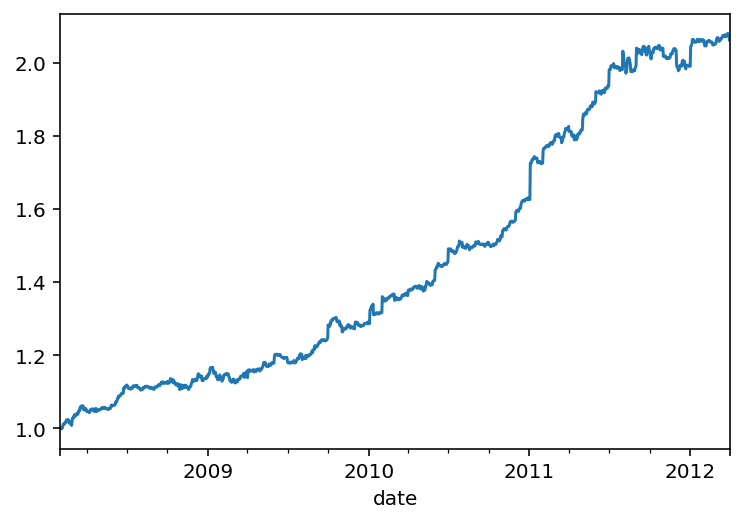

In [605]:
(port_return.droplevel("gvkey").resample("D").mean()+1).cumprod().plot()

<AxesSubplot:ylabel='Frequency'>

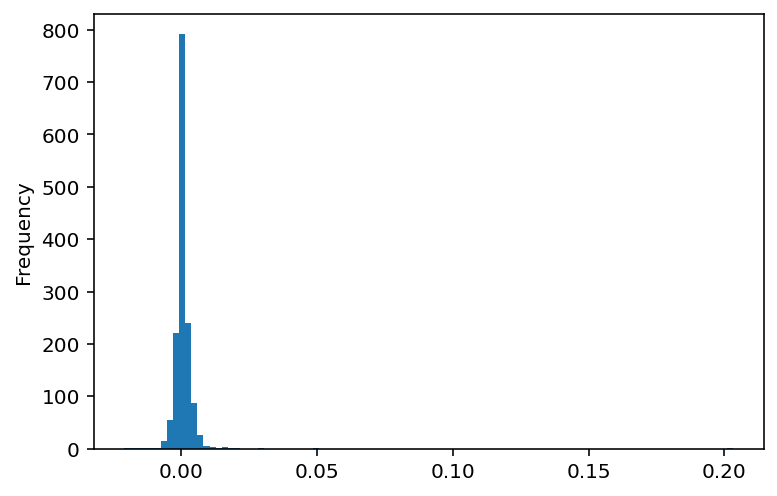

In [581]:
(port_return.droplevel("gvkey").resample("D").mean()).plot.hist(bins=100)